# Random Forest explainability on CLAP embeddings

*Used Python 3.9.25*

In [121]:
%pip install laion-clap huggingface-hub numpy pandas scikit-learn shap lime tqdm matplotlib torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [122]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import laion_clap
from huggingface_hub import hf_hub_download
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm 
import shap
import lime

np.random.seed(42)
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Clap model download and initialization

*Model used for creating embeddings is the same as in the original repository*

In [123]:
def get_clap_model():
    repo_id = "lukewys/laion_clap"
    filename = "music_audioset_epoch_15_esc_90.14.pt"
    
    print(f"Checking for model {filename}...")
    ckpt_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"Model path: {ckpt_path}")

    model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
    model.load_ckpt(ckpt_path)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Using CUDA...")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using MPS...")
    else:
        print("Using CPU...")

    model.to(device)
    model.eval()
    print(f"Model loaded on device: {device}")
    return model

clap_model = get_clap_model()

Checking for model music_audioset_epoch_15_esc_90.14.pt...
Model path: /Users/michal/.cache/huggingface/hub/models--lukewys--laion_clap/snapshots/b3708341862f581175dba5c356a4ebf74a9b6651/music_audioset_epoch_15_esc_90.14.pt


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint /Users/michal/.cache/huggingface/hub/models--lukewys--laion_clap/snapshots/b3708341862f581175dba5c356a4ebf74a9b6651/music_audioset_epoch_15_esc_90.14.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.a

## Data Preparation and Embedding Generation

In [ ]:
# Current configuration of folders and labels for experiment
base_dir = "data"
folders_map = {
    "real": 0,    # Class 0: Real
    "suno": 1,    # Class 1: AI Generated
    "udio": 1,
    "YuE": 1,
    "musicgen": 1
}

# Check if base directory exists
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Base directory '{base_dir}' does not exist")

# Check if folders exist
for folder in folders_map.keys():
    folder_path = os.path.join(base_dir, folder)
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder}' does not exist in base directory")

data_list = []

print("Starting audio processing...")

for folder_name, label in folders_map.items():
    # Search for files (mp3 and wav)
    search_path = os.path.join(base_dir, folder_name, "*")
    files = [f for f in glob.glob(search_path) if f.endswith(('.mp3', '.wav'))]

    if not files:
        print(f"Warning: No files found in folder: {folder_name}")
        continue

    print(f"Folder '{folder_name}': found {len(files)} files")

    # Process in batches to manage memory usage
    batch_size = 4 

    for i in tqdm(range(0, len(files), batch_size), desc=f"Processing {folder_name}"):
        batch_files = files[i:i + batch_size]
        try:
            # Generate embeddings
            with torch.no_grad():
                emb = clap_model.get_audio_embedding_from_filelist(x=batch_files, use_tensor=False)

            # Store results
            for idx, file_path in enumerate(batch_files):
                data_list.append({
                    "filename": file_path,
                    "label": label,
                    "source": folder_name,
                    "embedding": emb[idx]
                })

        except Exception as e:
            print(f"Error processing batch starting with {batch_files[0]}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data_list)
print(f"Finished! Processed {len(df)} tracks")

Starting audio processing...
Folder 'real': found 12 files


Processing real: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Folder 'suno': found 20 files


Processing suno: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Folder 'udio': found 20 files


Processing udio: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Folder 'YuE': found 23 files


Processing YuE: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Folder 'musicgen': found 20 files


Processing musicgen: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

Finished! Processed 95 tracks


In [125]:
# Expand the list of embeddings into separate columns (embed_0, embed_1, ...)
X = np.stack(df["embedding"].values)
feature_names = [f"embed_{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

y = df["label"].values

# Split into Train and Test sets (keeping indices to retrieve filenames later)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_df, y, df.index, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (76, 512)
Test set shape: (19, 512)


In [126]:
# Create folder for output plots
folder_name = "plots"

orig_cwd = os.getcwd()
os.makedirs(folder_name, exist_ok=True)
target_path = os.path.join(orig_cwd, folder_name)
print(f"Using folder for outputs: {target_path}")

Using folder for outputs: /Users/michal/Desktop/Michał/Dokumenty/Studia/II-stopień/WEITI/2 semestr/SIWY/SIWY-Deepfake-explainability/plots


## Random Forest training and evaluation

*Same model and hyperparameters as in the original repository*

In [127]:
# Initialize and train
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Report
print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=["Real (0)", "AI (1)"]))

# Confusion Matrix
print("--- CONFUSION MATRIX ---")
print(confusion_matrix(y_test, y_pred))

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Real (0)       0.67      1.00      0.80         2
      AI (1)       1.00      0.94      0.97        17

    accuracy                           0.95        19
   macro avg       0.83      0.97      0.88        19
weighted avg       0.96      0.95      0.95        19

--- CONFUSION MATRIX ---
[[ 2  0]
 [ 1 16]]


## LIME explanations for Random Forest on CLAP embeddings

In [128]:
print("Creating LIME Explanations...")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Real', 'AI'],
    mode='classification'
)

# Find indices of AI songs in the test set
ai_indices = np.where(y_test == 1)[0]

if len(ai_indices) > 0:
    # Pick the first AI song found
    i = ai_indices[0]
    
    # Get the actual data row and its original filename
    instance_row = X_test.iloc[i]
    original_idx = X_test.index[i]
    filename = df.loc[original_idx]['filename']
    actual_label = "AI" if y_test[i] == 1 else "Real"
    
    print(f"Explaining file: {filename}")
    print(f"Predicted Label: {'AI' if y_pred[i] == 1 else 'Real'}")
    print(f"Actual Label: {actual_label}")

    # predict_fn: The model's probability function
    exp_ai = explainer_lime.explain_instance(
        data_row=instance_row.values,
        predict_fn=rf_model.predict_proba
    )

    exp_ai.show_in_notebook()

    # Default save to HTML
    exp_ai.save_to_file(os.path.join(target_path, "rf_lime_explanation_ai.html"))

    # Save to PNG
    fig = exp_ai.as_pyplot_figure()
    plt.tight_layout()
    plt.title("LIME Explanation for AI Prediction")
    plt.grid(True)
    fig.savefig(os.path.join(target_path, "rf_lime_explanation_ai.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
else:
    print("No AI songs found in the test set to explain...")

real_indices = np.where(y_test == 0)[0]

if len(real_indices) > 0:
    i = real_indices[0]

    instance_row = X_test.iloc[i]
    original_idx = X_test.index[i]
    filename = df.loc[original_idx]['filename']
    actual_label = "AI" if y_test[i] == 1 else "Real"

    print(f"Explaining file: {filename}")
    print(f"Predicted Label: {'AI' if y_pred[i] == 1 else 'Real'}")
    print(f"Actual Label: {actual_label}")

    exp_real = explainer_lime.explain_instance(
        data_row=instance_row.values,
        predict_fn=rf_model.predict_proba
    )

    exp_real.show_in_notebook()

    exp_real.save_to_file(os.path.join(target_path, "rf_lime_explanation_real.html"))

    fig = exp_real.as_pyplot_figure()
    plt.tight_layout()
    plt.title("LIME Explanation for Real Prediction")
    plt.grid(True)
    fig.savefig(os.path.join(target_path, "rf_lime_explanation_real.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)
else:
    print("No Real songs found in the test set to explain...")

Creating LIME Explanations...
Explaining file: data/suno/Gone and Takenv35.mp3
Predicted Label: AI
Actual Label: AI


Explaining file: data/real/Finger Eleven - Paralyzer (Official HD Music Video).mp3
Predicted Label: Real
Actual Label: Real


## SHAP explanations for Random Forest on CLAP embeddings

Calculating SHAP values...


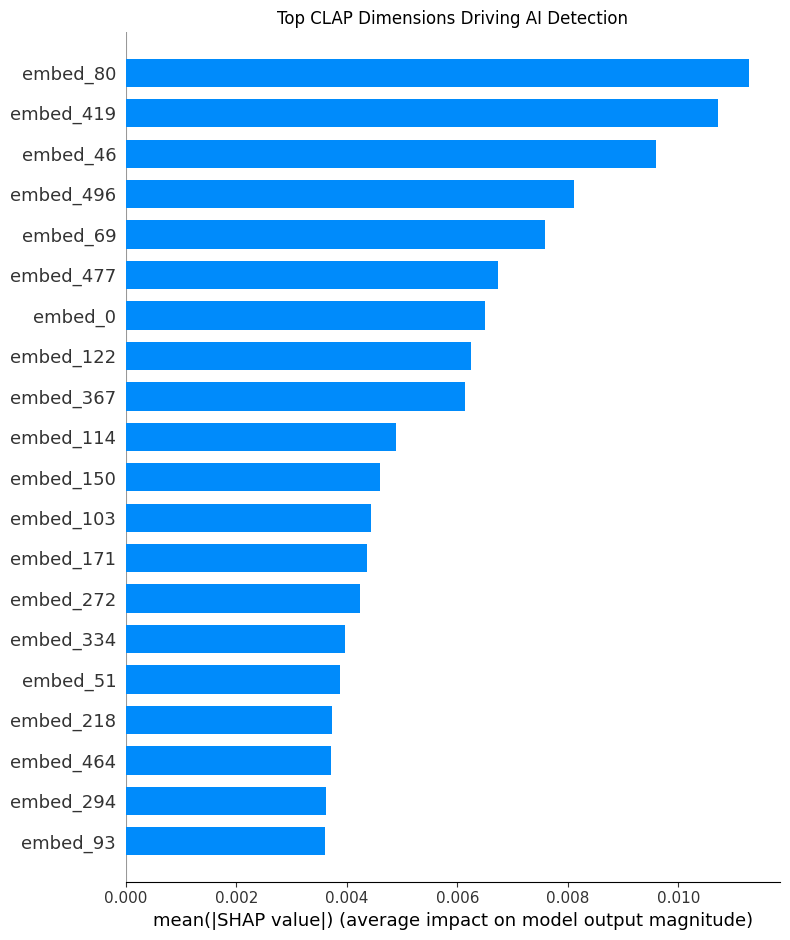

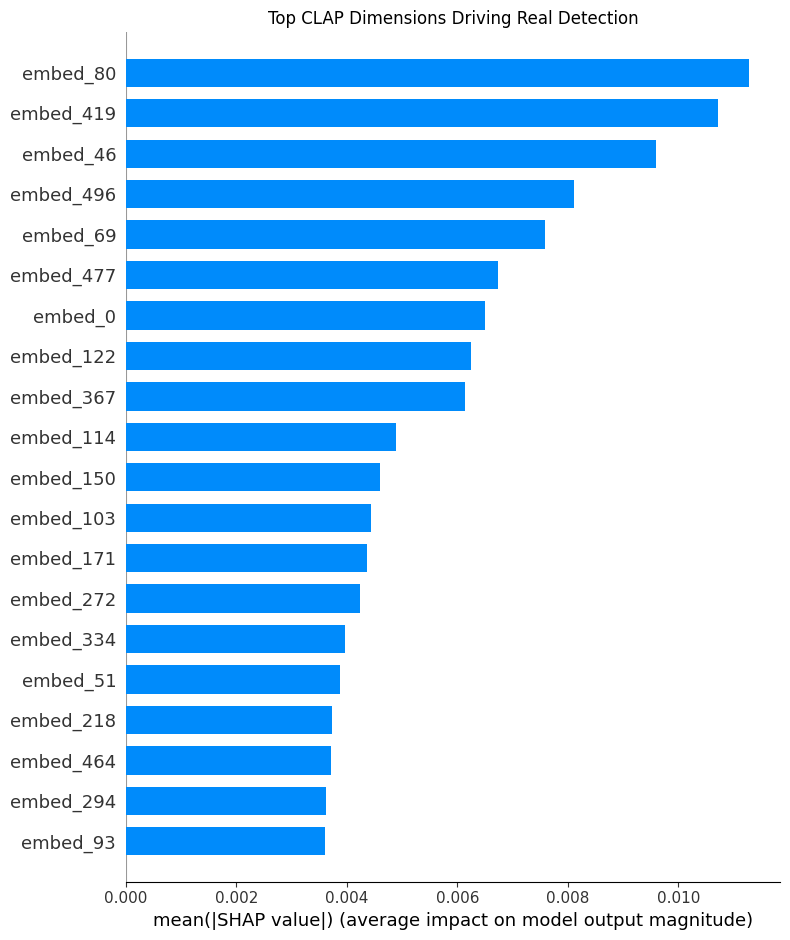

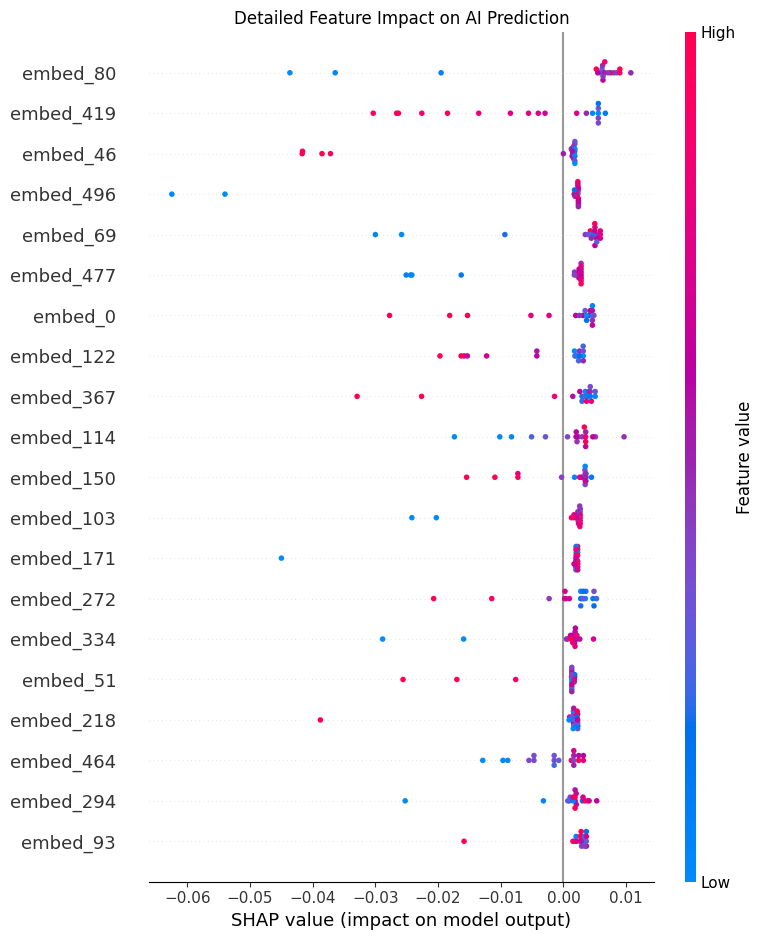

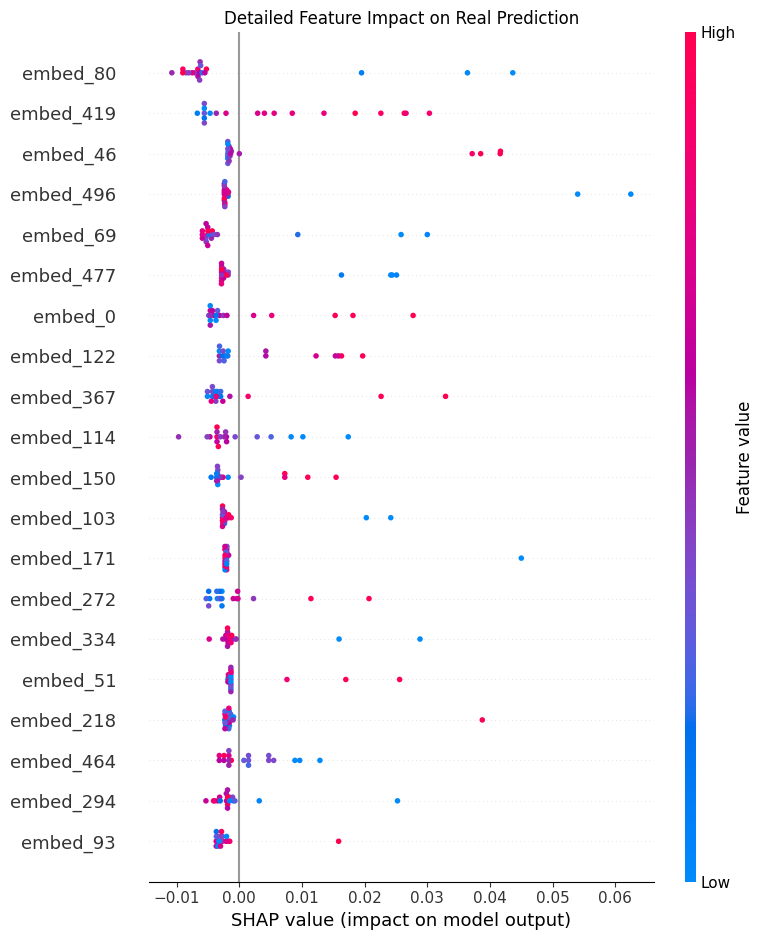

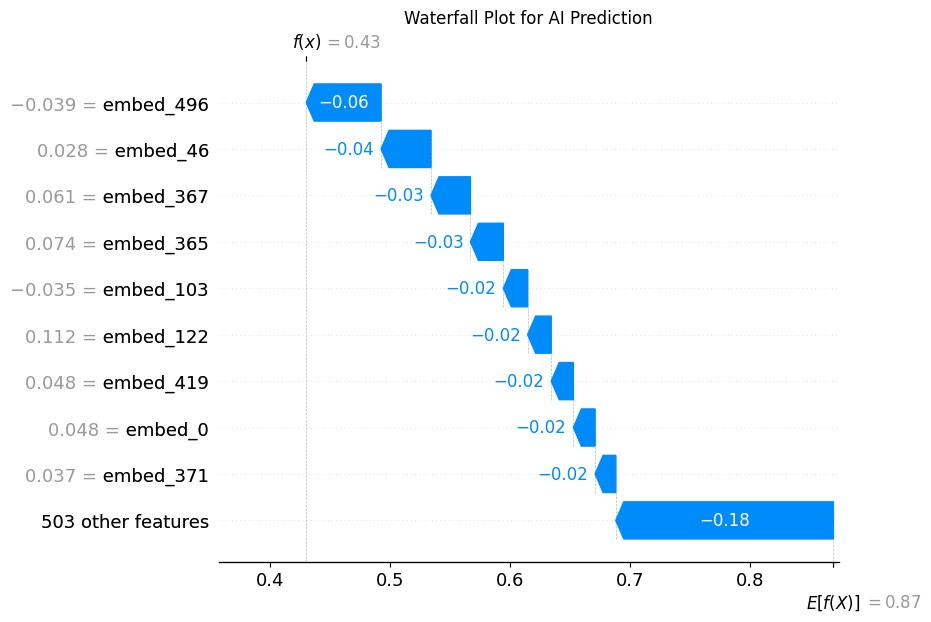

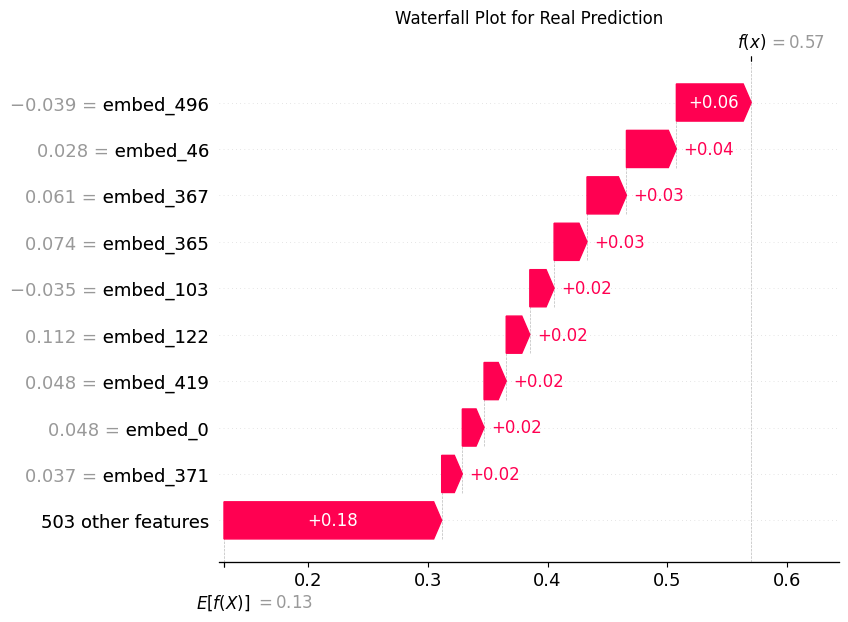

In [129]:
# Initialize TreeExplainer
explainer = shap.TreeExplainer(rf_model)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap_values_real = shap_values[:, :, 0]
shap_values_ai = shap_values[:, :, 1]

# Plot 1: Global Feature Importance
# Use show=False and grab the figure before saving to avoid blank images
plt.title("Top CLAP Dimensions Driving AI Detection")
shap.summary_plot(shap_values_ai, X_test, plot_type="bar")
shap.summary_plot(shap_values_ai, X_test, plot_type="bar", show=False)
fig = plt.gcf()
fig.suptitle("Top CLAP Dimensions Driving AI Detection")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_summary_ai.png"))
plt.close(fig)

plt.title("Top CLAP Dimensions Driving Real Detection")
shap.summary_plot(shap_values_real, X_test, plot_type="bar")
shap.summary_plot(shap_values_real, X_test, plot_type="bar", show=False)
fig = plt.gcf()
fig.suptitle("Top CLAP Dimensions Driving Real Detection")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_summary_real.png"))
plt.close()

# Plot 2: Detailed Beeswarm Plot
plt.title("Detailed Feature Impact on AI Prediction")
shap.summary_plot(shap_values_ai, X_test)
shap.summary_plot(shap_values_ai, X_test, show=False)
fig = plt.gcf()
fig.suptitle("Detailed Feature Impact on AI Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_beeswarm_ai.png"))
plt.close()

plt.title("Detailed Feature Impact on Real Prediction")
shap.summary_plot(shap_values_real, X_test)
shap.summary_plot(shap_values_real, X_test, show=False)
fig = plt.gcf()
fig.suptitle("Detailed Feature Impact on Real Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_beeswarm_real.png"))
plt.close()

# Plot 3: Dependence Plot for Top Feature
explanation_ai = shap.Explanation(
    values=shap_values_ai,
    base_values=np.full(X_test.shape[0], explainer.expected_value[1]),
    data=X_test.values,
    feature_names=feature_names,
)

explanation_real = shap.Explanation(
    values=shap_values_real,
    base_values=np.full(X_test.shape[0], explainer.expected_value[0]),
    data=X_test.values,
    feature_names=feature_names,
)

plt.title("Waterfall Plot for AI Prediction")
shap.plots.waterfall(explanation_ai[1])
shap.plots.waterfall(explanation_ai[1], show=False)
fig = plt.gcf()
fig.suptitle("Waterfall Plot for AI Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_waterfall_ai.png"))
plt.close()

plt.title("Waterfall Plot for Real Prediction")
shap.plots.waterfall(explanation_real[1])
shap.plots.waterfall(explanation_real[1], show=False)
fig = plt.gcf()
fig.suptitle("Waterfall Plot for Real Prediction")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(target_path, "shap_waterfall_real.png"))
plt.close()